In [302]:
from copulae1 import *
import os
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
np.random.seed(0)


In [303]:
data = pd.read_csv('../data/btc future and reference rate/coingecko_future.csv')
brr = data.iloc[:,4]
btc = data.iloc[:,5]

u = ECDF(brr)(brr)
v = ECDF(btc)(btc)

In [304]:
import json
with open('../src/configs/config_coingecko_future_v3_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"

In [305]:
natp_path = '../_mathematica/data/'
natp_ls = os.listdir(natp_path)
natp_h = [l for l in natp_ls if l.endswith('_h.csv')]
file_names = [l.replace('_h','') for l in natp_h]
OHR_combined = []
for i in range(len(natp_h)):
    _natp_h = pd.DataFrame(open(natp_path+natp_h[i], 'r').readlines())
    _natp_h = _natp_h.iloc[1:7,:]
    file_name = natp_h[i].replace('_h','')
    for i in range(len(_natp_h)):
        _natp_h.iloc[i,0] = np.float32(_natp_h.iloc[i,0].replace('\n',''))
    _natp_h.columns = ['NIG_factor']
    _natp_h.index = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 'ES q=0.01', 'ES q=0.05', 'ERM k=10']
    _natp_h = _natp_h.T
    
    OHR_combined.append(OHR.loc[:,file_name].append(_natp_h))
OHR = pd.concat(OHR_combined, axis=1, keys=file_names).dropna(axis=1)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [306]:
Copula_names = list(OHR.index)
risk_measures = OHR.loc[:,'0.csv'].columns
data_path = '../processed_data/'+config['data_name']
ls = os.listdir(data_path +'/train/')
# OHR.loc[:,'0.csv'].loc[:,risk_measures[0]]

In [307]:
block_size = 100
_ids = [(i, i+block_size) for i in range(0, len(rs)-block_size)]

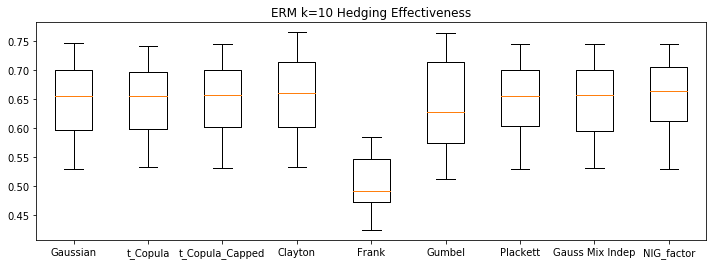

In [320]:
rm = 'ERM k=10'
rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

rs = pd.concat(rs_arr).sort_index()
rf = pd.concat(rf_arr).sort_index()
rh = pd.concat(rh_arr, axis=1)
rh = rh.T.sort_index().T
rs_blocks = [rs[_id[0]:_id[1]] for _id in _ids]
rh_blocks = [rh.iloc[:, _id[0]:_id[1]] for _id in _ids]
results = []
for C in Copula_names:
    _results = []
    for _ in range(1000):
        i = np.random.choice(range(len(rs_blocks)), 1)[0]
        rho_h = ERM_estimate_trapezoidal(10, rh_blocks[i].loc[C,:])
        rho_s = ERM_estimate_trapezoidal(10, rs_blocks[i])
        _results.append(1-rho_h/rho_s)
    results.append(_results)

plt.figure(figsize=(12,4))
plt.boxplot(results)
plt.xticks(range(1,len(Copula_names)+1),Copula_names)
plt.title("ERM k=10 Hedging Effectiveness")
plt.savefig('../results/coingecko_future_v3/HE_ERM10_BS.pdf')

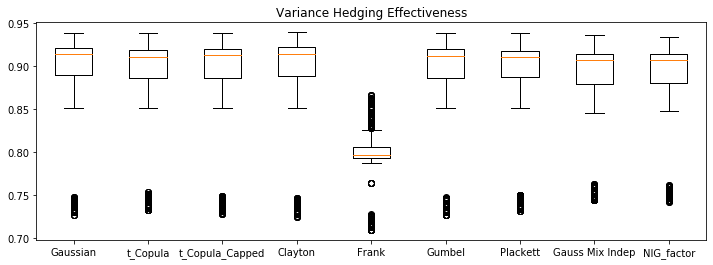

In [319]:
rm = 'Variance'

rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

rs = pd.concat(rs_arr).sort_index()
rf = pd.concat(rf_arr).sort_index()
rh = pd.concat(rh_arr, axis=1)
rh = rh.T.sort_index().T
rs_blocks = [rs[_id[0]:_id[1]] for _id in _ids]
rh_blocks = [rh.iloc[:, _id[0]:_id[1]] for _id in _ids]
results = []
for C in Copula_names:
    _results = []
    for _ in range(1000):
        i = np.random.choice(range(len(rs_blocks)), 1)[0]
        rho_h = Variance(rh_blocks[i].loc[C,:])
        rho_s = Variance(rs_blocks[i])
        _results.append(1-rho_h/rho_s)
    results.append(_results)
    
plt.figure(figsize=(12,4))
plt.boxplot(results)
plt.xticks(range(1,len(Copula_names)+1),Copula_names)
plt.title("Variance Hedging Effectiveness")
plt.savefig('../results/coingecko_future_v3/HE_Variance_BS.pdf')

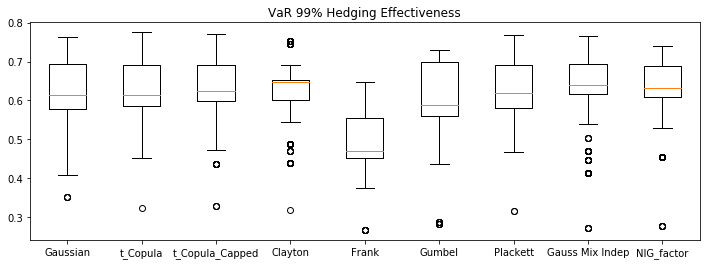

In [318]:
rm = 'VaR q=0.01'

rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

rs = pd.concat(rs_arr).sort_index()
rf = pd.concat(rf_arr).sort_index()
rh = pd.concat(rh_arr, axis=1)
rh = rh.T.sort_index().T
rs_blocks = [rs[_id[0]:_id[1]] for _id in _ids]
rh_blocks = [rh.iloc[:, _id[0]:_id[1]] for _id in _ids]

results = []
for C in Copula_names:
    _results = []
    for _ in range(1000):
        i = np.random.choice(range(len(rs_blocks)), 1)[0]
        rho_h = VaR(0.01, rh_blocks[i].loc[C,:])
        rho_s = VaR(0.01, rs_blocks[i])
        _results.append(1-rho_h/rho_s)
    results.append(_results)
    
plt.figure(figsize=(12,4))
plt.boxplot(results)
plt.xticks(range(1,len(Copula_names)+1),Copula_names)
plt.title("VaR 99% Hedging Effectiveness")
plt.savefig('../results/coingecko_future_v3/HE_VaR99_BS.pdf')

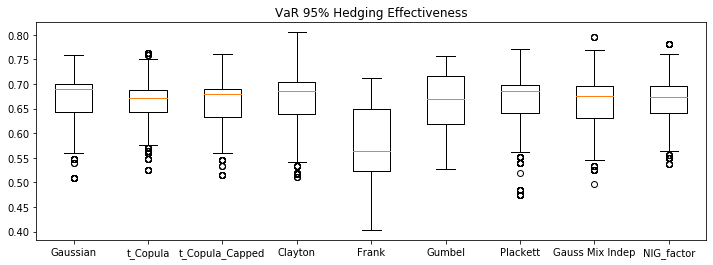

In [317]:
rm = 'VaR q=0.05'

rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

rs = pd.concat(rs_arr).sort_index()
rf = pd.concat(rf_arr).sort_index()
rh = pd.concat(rh_arr, axis=1)
rh = rh.T.sort_index().T
rs_blocks = [rs[_id[0]:_id[1]] for _id in _ids]
rh_blocks = [rh.iloc[:, _id[0]:_id[1]] for _id in _ids]

results = []
for C in Copula_names:
    _results = []
    for _ in range(1000):
        i = np.random.choice(range(len(rs_blocks)), 1)[0]
        rho_h = VaR(0.05, rh_blocks[i].loc[C,:])
        rho_s = VaR(0.05, rs_blocks[i])
        _results.append(1-rho_h/rho_s)
    results.append(_results)
    
plt.figure(figsize=(12,4))
plt.boxplot(results)
plt.xticks(range(1,len(Copula_names)+1),Copula_names)
plt.title("VaR 95% Hedging Effectiveness")
plt.savefig('../results/coingecko_future_v3/HE_VaR95_BS.pdf')

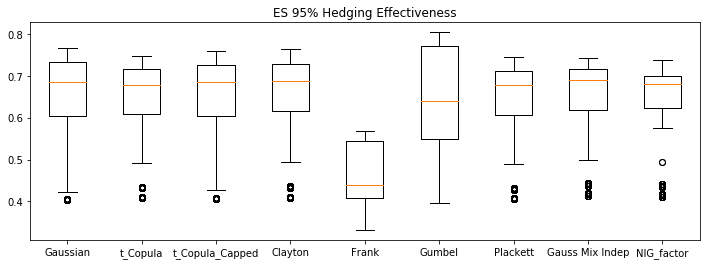

In [316]:
rm = 'ES q=0.05'

rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

rs = pd.concat(rs_arr).sort_index()
rf = pd.concat(rf_arr).sort_index()
rh = pd.concat(rh_arr, axis=1)
rh = rh.T.sort_index().T
rs_blocks = [rs[_id[0]:_id[1]] for _id in _ids]
rh_blocks = [rh.iloc[:, _id[0]:_id[1]] for _id in _ids]

results = []
for C in Copula_names:
    _results = []
    for _ in range(1000):
        i = np.random.choice(range(len(rs_blocks)), 1)[0]
        rho_h = ES(0.05, rh_blocks[i].loc[C,:])
        rho_s = ES(0.05, rs_blocks[i])
        _results.append(1-rho_h/rho_s)
    results.append(_results)
    
plt.figure(figsize=(12,4))
plt.boxplot(results)
plt.xticks(range(1,len(Copula_names)+1),Copula_names)
plt.title("ES 95% Hedging Effectiveness")
plt.plot()
plt.savefig('../results/coingecko_future_v3/HE_ES95_BS.pdf')

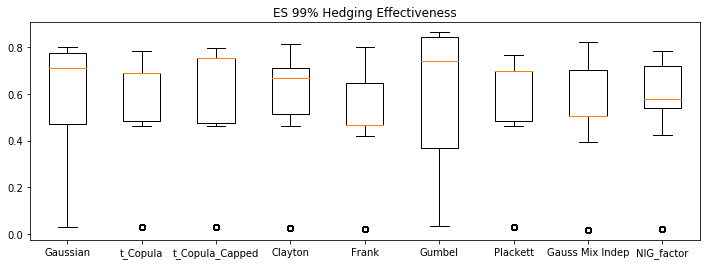

In [315]:
rm = 'ES q=0.01'

rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

rs = pd.concat(rs_arr).sort_index()
rf = pd.concat(rf_arr).sort_index()
rh = pd.concat(rh_arr, axis=1)
rh = rh.T.sort_index().T
rs_blocks = [rs[_id[0]:_id[1]] for _id in _ids]
rh_blocks = [rh.iloc[:, _id[0]:_id[1]] for _id in _ids]

results = []
for C in Copula_names:
    _results = []
    for _ in range(1000):
        i = np.random.choice(range(len(rs_blocks)), 1)[0]
        rho_h = ES(0.01, rh_blocks[i].loc[C,:])
        rho_s = ES(0.01, rs_blocks[i])
        _results.append(1-rho_h/rho_s)
    results.append(_results)
    
plt.figure(figsize=(12,4))
plt.boxplot(results)
plt.xticks(range(1,len(Copula_names)+1),Copula_names)
plt.title("ES 99% Hedging Effectiveness")
plt.savefig('../results/coingecko_future_v3/HE_ES99_BS.pdf')